## Project 6

In [2]:
import os
import subprocess
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import scipy
import requests
from imdbpie import Imdb
import nltk
import matplotlib.pyplot as plt
import urllib
from bs4 import BeautifulSoup
import collections
import re
import csv
import psycopg2

%matplotlib inline

### Pre-Work: Write a problem statement 

What factors of a movie contribute to a good rating?

## Part 1: Acquire the Data

#### 1. Connect to the IMDB API

In [3]:
imdb = Imdb(anonymize=True)


#### 2. Query the top 250 rated movies in the database

In [4]:
top250 = imdb.top_250()

#### 3. Only select the top 25 movies and delete the uncessary rows

In [5]:
top25 = pd.DataFrame(top250[0:24])
top25 = top25.drop('image', axis=1)
top25

,can_rate,num_votes,rating,tconst,title,type,year
0,True,1718456,9.3,tt0111161,The Shawshank Redemption,feature,1994
1,True,1174559,9.2,tt0068646,The Godfather,feature,1972
2,True,804922,9.0,tt0071562,The Godfather: Part II,feature,1974
3,True,1704632,9.0,tt0468569,The Dark Knight,feature,2008
4,True,457572,8.9,tt0050083,12 Angry Men,feature,1957
5,True,880006,8.9,tt0108052,Schindler's List,feature,1993
6,True,1346366,8.9,tt0110912,Pulp Fiction,feature,1994
7,True,1234876,8.9,tt0167260,The Lord of the Rings: The Return of the King,feature,2003
8,True,511565,8.9,tt0060196,"The Good, the Bad and the Ugly",feature,1966
9,True,1371582,8.8,tt0137523,Fight Club,feature,1999


#### 4. Write the Results to a csv

In [6]:
top25.to_csv('top25.csv')

## Part 2: Wrangle the text data

#### 1. Convert the listing identification numbers (tconst) from the first dataframe to a list

In [7]:
listing_id = list(top25['tconst'])

#### 2. Scrape the reviews for the top 25 movies

*Hint*: Use a loop to scrape each page at once

In [8]:
#df = pd.DataFrame(columns=['movie_title', 'review_title', 'stars', 'review_text'])
#for title in listing_id:
#    url = 'http://www.imdb.com/title/{}/reviews?count=5000&start=0'.format(title)
#    r = requests.get(url)
#    soup = BeautifulSoup(r.text, 'lxml')
#    df.review_title = soup.find_all('div', 'h2')
#    df.stars = soup.find_all('img', 'alt=')
#    df.review_main = soup.find_all('p', text)
#    df.movie_title = title

In [9]:
df = pd.DataFrame(data = [], columns=['movie_title', 'review_title', 'stars', 'review_text'])

for title in listing_id:
    new_df = pd.DataFrame(data = [], columns=['movie_title', 'review_title', 'stars', 'review_text'])
    reviews = imdb.get_title_reviews(title, max_results=4000)
    rev_titles = []
    rev_stars = []
    rev_text = []
    for rev in reviews:
        rev_titles.append(rev.summary)
        rev_stars.append(rev.rating)
        rev_text.append(rev.text)
    new_df.review_title = rev_titles
    new_df.stars = rev_stars
    new_df.review_text = rev_text
    new_df.movie_title = top25.set_index('tconst').title[title]
    df = pd.concat([df, new_df])
    del new_df

df.head()

,movie_title,review_title,stars,review_text
0,The Shawshank Redemption,Tied for the best movie I have ever seen,10.0,Why do I want to write the 234th comment on Th...
1,The Shawshank Redemption,Shawshank Redeems Hollywood,10.0,"\nCan Hollywood, usually creating things for e..."
2,The Shawshank Redemption,Prepare to be moved,NaN,\nI have never seen such an amazing film since...
3,The Shawshank Redemption,A classic piece of unforgettable film-making.,10.0,"In its Oscar year, Shawshank Redemption (writt..."
4,The Shawshank Redemption,Two movies in one,NaN,The reason I became a member of this database ...


#### 3. Work through each title and find the most common descriptors

*Hint*: "soup" from BeautifulSoup is the html returned from all 25 pages. You'll need to either address each page individually or break them down by elements

In [10]:
collections.Counter(df.review_title.dropna()).most_common(15)

[(u'Amazing', 113),
 (u'Excellent', 93),
 (u'Great Movie', 91),
 (u'Masterpiece', 83),
 (u'Awesome', 78),
 (u'Brilliant', 77),
 (u'Great movie', 64),
 (u'Overrated', 52),
 (u'Fantastic', 49),
 (u'Great', 41),
 (u'Wow', 40),
 (u'great movie', 39),
 (u'A Masterpiece', 37),
 (u'Best movie ever', 35),
 (u'Perfect', 34)]

#### 4. Convert to a string and remove the non AlphaNumeric characters

*Hint*: Use regular expressions!

#### 5. Tokenize the Output

#### 6. Convert to a Dataframe for Easy Viewing

####  7. Find the rows with the top five descriptive words

In [11]:
words = ('best', 'hope', 'love', 'beautiful', 'great')

#### 8. Write the results to a csv

In [12]:
df.to_csv('movie_reviews.csv', encoding='utf-8')

## Part 3: Combine Tables in PostgreSQL

#### 1. Import your two .csv data files into your Postgre Database as two different tables

For ease, we can call these table1 and table2

In [13]:
from sqlalchemy import create_engine
engine = create_engine('postgresql://useraj@localhost:5432/project6_db')

try:
    conn=psycopg2.connect("dbname='project6_db' user='useraj' host='localhost'")
except:
    print "I am unable to connect to the database."

cur = conn.cursor()
#df.to_sql("table1", engine)

In [14]:
#top25.to_sql("table2", engine)

#### 2. Connect to database and query the joined set

In [15]:
cur.execute("""SELECT DISTINCT movie_title FROM table1""")

test = cur.fetchall()

In [16]:
test

[('Star Wars: Episode V - The Empire Strikes Back',),
 ('The Matrix',),
 ('The Silence of the Lambs',),
 ('Pulp Fiction',),
 ("Schindler's List",),
 ('The Good, the Bad and the Ugly',),
 ('City of God',),
 ('Forrest Gump',),
 ('Star Wars: Episode IV - A New Hope',),
 ('The Dark Knight',),
 ('The Lord of the Rings: The Two Towers',),
 ('The Godfather',),
 ('The Lord of the Rings: The Return of the King',),
 ('The Godfather: Part II',),
 ('Inception',),
 ('Se7en',),
 ('12 Angry Men',),
 ('Goodfellas',),
 ('Fight Club',),
 ("One Flew Over the Cuckoo's Nest",),
 ("It's a Wonderful Life",),
 ('The Shawshank Redemption',),
 ('The Lord of the Rings: The Fellowship of the Ring',),
 ('Seven Samurai',)]

#### 3. Join the two tables 

In [17]:
cur.execute("""SELECT * FROM table1
                JOIN table2 ON table2.title = table1.movie_title""")
big_df = pd.DataFrame(cur.fetchall())

#### 4. Select the newly joined table and save two copies of the into dataframes

In [18]:
big_df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0,The Shawshank Redemption,Tied for the best movie I have ever seen,10.0,Why do I want to write the 234th comment on Th...,0,True,1718456,9.3,tt0111161,The Shawshank Redemption,feature,1994
1,1,The Shawshank Redemption,Shawshank Redeems Hollywood,10.0,"\nCan Hollywood, usually creating things for e...",0,True,1718456,9.3,tt0111161,The Shawshank Redemption,feature,1994
2,2,The Shawshank Redemption,Prepare to be moved,NaN,\nI have never seen such an amazing film since...,0,True,1718456,9.3,tt0111161,The Shawshank Redemption,feature,1994


## Part 4: Parsing and Exploratory Data Analysis

#### 1. Rename the column headings

In [19]:
big_df.columns = ['kill', 'movie_title', 'review_title', 'rating', 'review_text', 'kill',
                  'kill', 'number_of_ratings', 'average_rating', 'imdb_code', 'kill', 'kill', 'release_date']

In [20]:
big_df.head(3)

,kill,movie_title,review_title,rating,review_text,kill,kill,number_of_ratings,average_rating,imdb_code,kill,kill,release_date
0,0,The Shawshank Redemption,Tied for the best movie I have ever seen,10.0,Why do I want to write the 234th comment on Th...,0,True,1718456,9.3,tt0111161,The Shawshank Redemption,feature,1994
1,1,The Shawshank Redemption,Shawshank Redeems Hollywood,10.0,"\nCan Hollywood, usually creating things for e...",0,True,1718456,9.3,tt0111161,The Shawshank Redemption,feature,1994
2,2,The Shawshank Redemption,Prepare to be moved,NaN,\nI have never seen such an amazing film since...,0,True,1718456,9.3,tt0111161,The Shawshank Redemption,feature,1994


In [21]:
for col in big_df.columns:
    if col == 'kill':
        big_df = big_df.drop(col, axis=1)

ValueError: labels ['kill'] not contained in axis

In [22]:
big_df.release_date.astype('int', inplace=True)
big_df.head(3)

,movie_title,review_title,rating,review_text,number_of_ratings,average_rating,imdb_code,release_date
0,The Shawshank Redemption,Tied for the best movie I have ever seen,10.0,Why do I want to write the 234th comment on Th...,1718456,9.3,tt0111161,1994
1,The Shawshank Redemption,Shawshank Redeems Hollywood,10.0,"\nCan Hollywood, usually creating things for e...",1718456,9.3,tt0111161,1994
2,The Shawshank Redemption,Prepare to be moved,NaN,\nI have never seen such an amazing film since...,1718456,9.3,tt0111161,1994


In [23]:
print big_df.shape
print big_df.dropna().shape

(44907, 8)
(38547, 8)


#### 2. Run a description of the data

In [24]:
big_df.dropna().describe()

,rating,number_of_ratings,average_rating
count,38547.000000,3.854700e+04,38547.000000
mean,8.780087,1.220263e+06,8.875209
std,2.241808,3.665769e+05,0.192182
min,1.000000,2.329460e+05,8.600000
25%,9.000000,1.042796e+06,8.700000
50%,10.000000,1.237777e+06,8.800000
75%,10.000000,1.495184e+06,9.000000
max,10.000000,1.718456e+06,9.300000


#### 3. Visualize the Data

(array([  1422.,    415.,    490.,    485.,    760.,   1040.,   1637.,
          2903.,   5891.,  23508.]),
 array([  1. ,   1.9,   2.8,   3.7,   4.6,   5.5,   6.4,   7.3,   8.2,
          9.1,  10. ]),
 <a list of 10 Patch objects>)

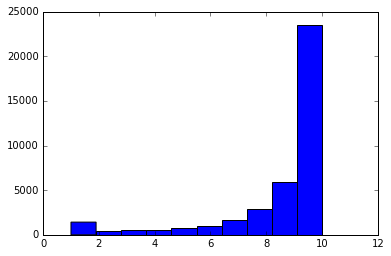

In [25]:
plt.hist(big_df.rating.dropna())

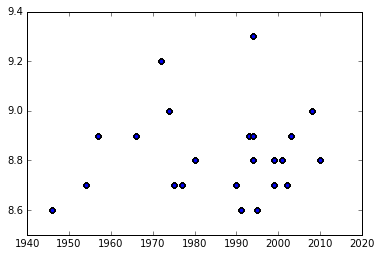

In [26]:
plt.scatter(big_df[['release_date']], big_df.average_rating)

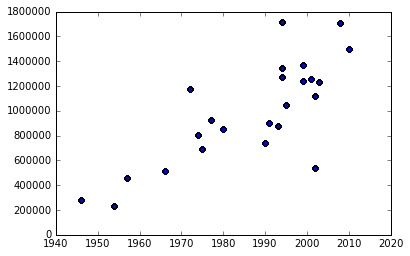

In [27]:
plt.scatter(big_df[['release_date']], big_df.number_of_ratings)

## Part 3: Build the Decision Tree

#### 1. What is our target attribute? 

Movie Ratings

#### 2. Prepare the data and define the training set

In [33]:
movies = big_df.dropna()
tfidf = TfidfVectorizer(stop_words='english')
X = tfidf.fit_transform(movies.review_title)

In [34]:
y = movies.rating
X_train, X_test, y_train, y_test = train_test_split(X, y)

#### 2. Train the Model

In [35]:
forest = RandomForestRegressor(n_jobs=-1)
#params = {'n_estimators': [8, 10, 12],
#          'max_depth': [None, 10, 15],
#          'min_samples_split': [2, 3]}
#grid = GridSearchCV(forest, params)
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [36]:
#print grid.best_score_
#print grid.best_params_

#### 3. Set up test data and test the model

In [37]:
#best_forest = grid.best_estimator_
y_pred = forest.predict(X_test)

#### 5. Check the results

In [58]:
zip(tfidf.get_feature_names(), forest.feature_importances_)

[(u'00', 0.0),
 (u'000', 6.9525531951677624e-07),
 (u'007', 8.9146108103988909e-06),
 (u'03', 0.0),
 (u'08', 9.3761751856846461e-05),
 (u'10', 0.00085675654152789357),
 (u'100', 9.2177154862892985e-05),
 (u'1000', 0.0),
 (u'100m', 6.5282946698183726e-06),
 (u'101', 1.6192349622490708e-06),
 (u'10s', 2.1198591388600845e-06),
 (u'10tenx10tenx10tenx10tenx10tenx10tenx10tenx10tenx', 0.0),
 (u'10th', 0.0),
 (u'10x', 0.0),
 (u'11', 0.00011062368602479504),
 (u'110', 3.5817930264995657e-05),
 (u'110th', 1.6935639494744555e-06),
 (u'11th', 0.0),
 (u'12', 0.00066549671327849802),
 (u'123', 5.9229635877320389e-06),
 (u'13', 1.536139280403709e-06),
 (u'131', 1.4102975131018255e-05),
 (u'139', 7.9846033675465879e-05),
 (u'13h30', 0.0),
 (u'13th', 0.0),
 (u'14', 5.797985761213583e-05),
 (u'140', 0.00013952310305398219),
 (u'142', 0.0),
 (u'148', 8.1406281114225776e-07),
 (u'14th', 0.0),
 (u'15', 8.8379958012075115e-06),
 (u'1500', 0.0),
 (u'153', 0.0),
 (u'15th', 0.0),
 (u'16', 7.0555970814969311e-0

#### 6. What is overfitting and how are we at risk? 